# PUOCH MABOR MAKUEI S23B23/055 9/11/25

# Crop Recommendation using Ensemble Techniques

## Project Overview
This notebook demonstrates the implementation and comparison of two key ensemble machine learning techniques for crop recommendation based on soil and environmental conditions.

## Dataset Information
- **Source**: Crop Recommendation Dataset
- **Features**: N, P, K (soil nutrients), temperature, humidity, pH, rainfall
- **Target**: 22 different crop types
- **Size**: 2200 samples (100 per crop)

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
confusion_matrix, classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To  Load the dataset
PATH = 'Crop_recommendation.csv' # 
try:
    df = pd.read_csv(PATH)
except Exception as e:
    raise FileNotFoundError(f"Could not load {PATH}. Please download the Crop Recommendation dataset from Kaggle and place it here. Original error: {e}")


print('Dataset shape:', df.shape)
print(df.columns.tolist())

Dataset shape: (2200, 8)
['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']


In [ ]:
# Quick EDA
print('\nValue counts for target (label):')
print(df['label'].value_counts())
print('\nDescribe:')
print(df.describe().T)



Value counts for target (label):
label
muskmelon      100
watermelon     100
cotton         100
grapes         100
kidneybeans    100
rice           100
pigeonpeas     100
chickpea       100
orange         100
coffee         100
maize          100
jute           100
pomegranate    100
coconut        100
blackgram      100
lentil         100
mungbean       100
mothbeans      100
mango          100
apple          100
papaya         100
banana         100
Name: count, dtype: int64

Describe:
              count        mean        std        min        25%        50%  \
N            2200.0   50.551818  36.917334   0.000000  21.000000  37.000000   
P            2200.0   53.362727  32.985883   5.000000  28.000000  51.000000   
K            2200.0   48.149091  50.647931   5.000000  20.000000  32.000000   
temperature  2200.0   25.616244   5.063749   8.825675  22.769375  25.598693   
humidity     2200.0   71.481779  22.263812  14.258040  60.261953  80.473146   
ph           2200.0    6.469480

## 1. Enhanced Exploratory Data Analysis

Let's perform a comprehensive analysis of our dataset to understand the data distribution, correlations, and patterns.

Dataset Info:
Shape: (2200, 8)
Missing values: 0
Duplicate rows: 0


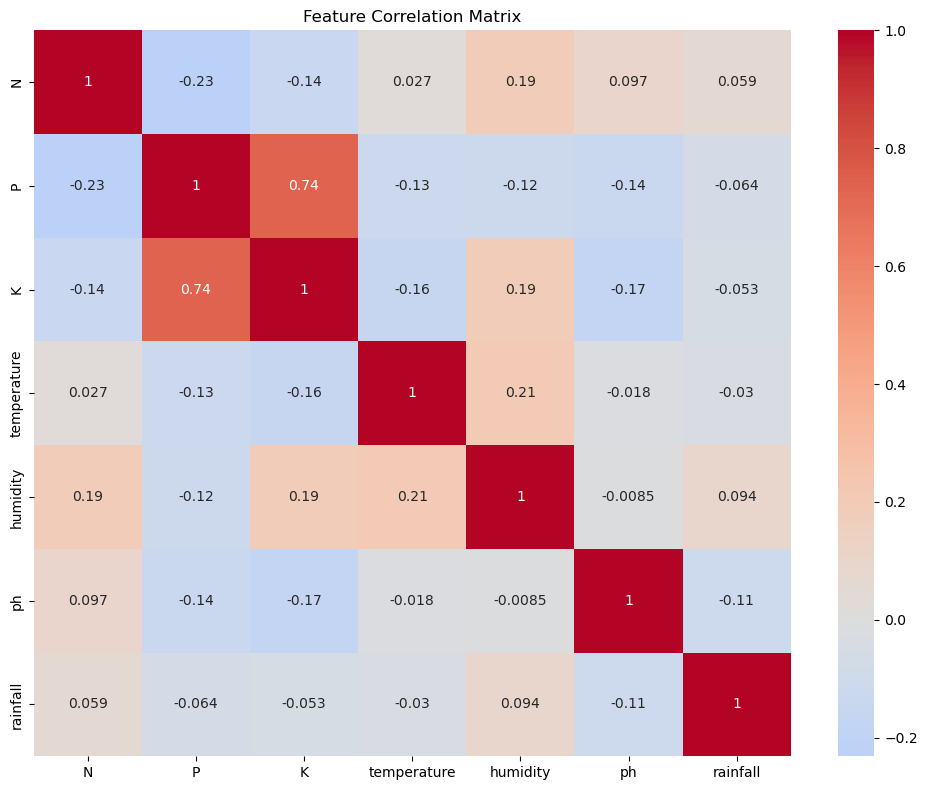

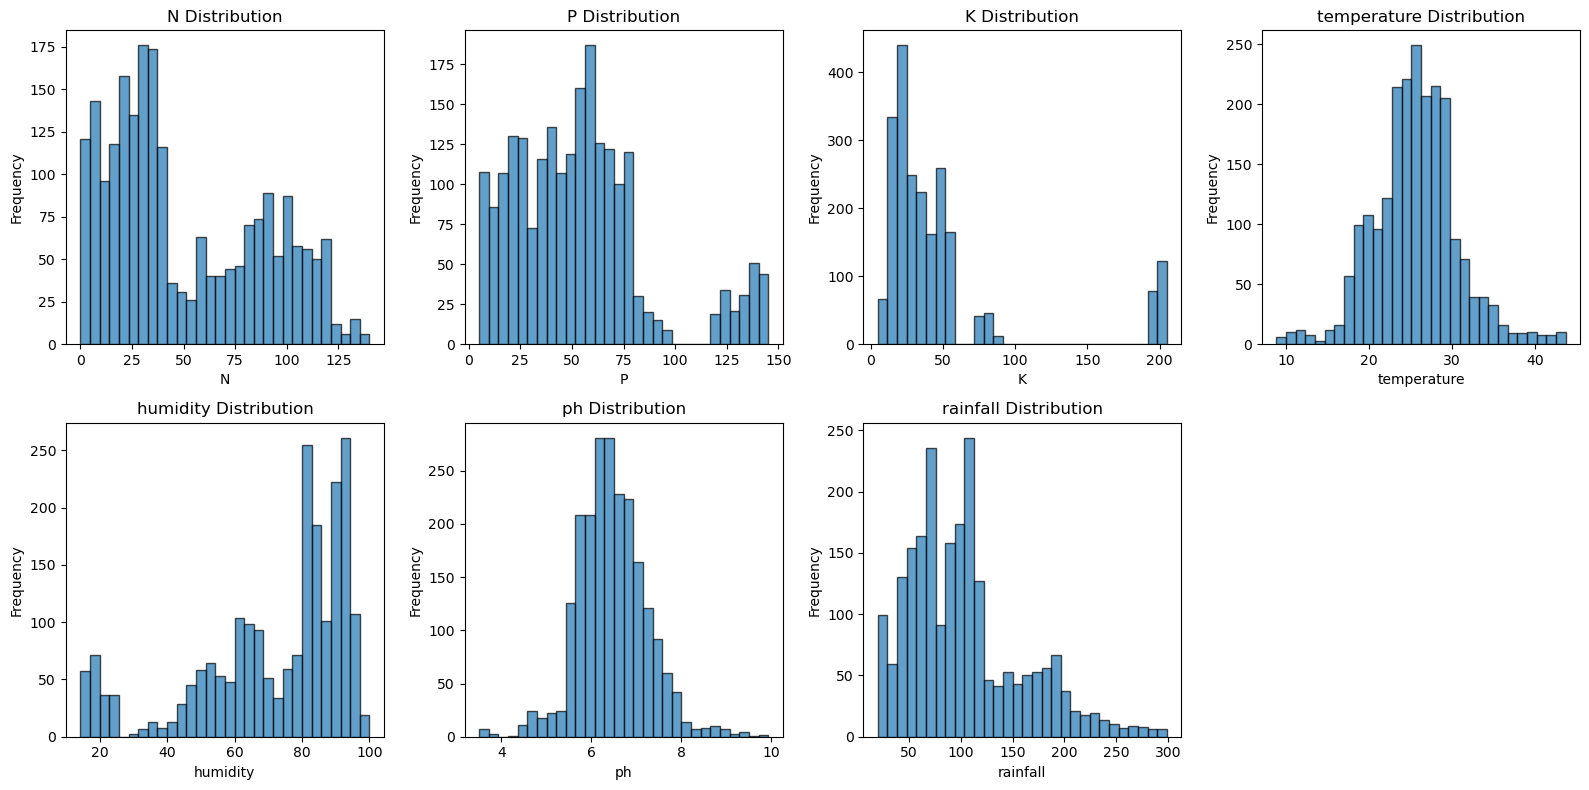

In [13]:
# Enhanced EDA - Correlation Analysis and Feature Distributions
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Feature distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
for i, feature in enumerate(features):
    row, col = i // 4, i % 4
    axes[row, col].hist(df[feature], bins=30, edgecolor='black', alpha=0.7)
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')

# Remove the empty subplot
axes[1, 3].remove()
plt.tight_layout()
plt.show()

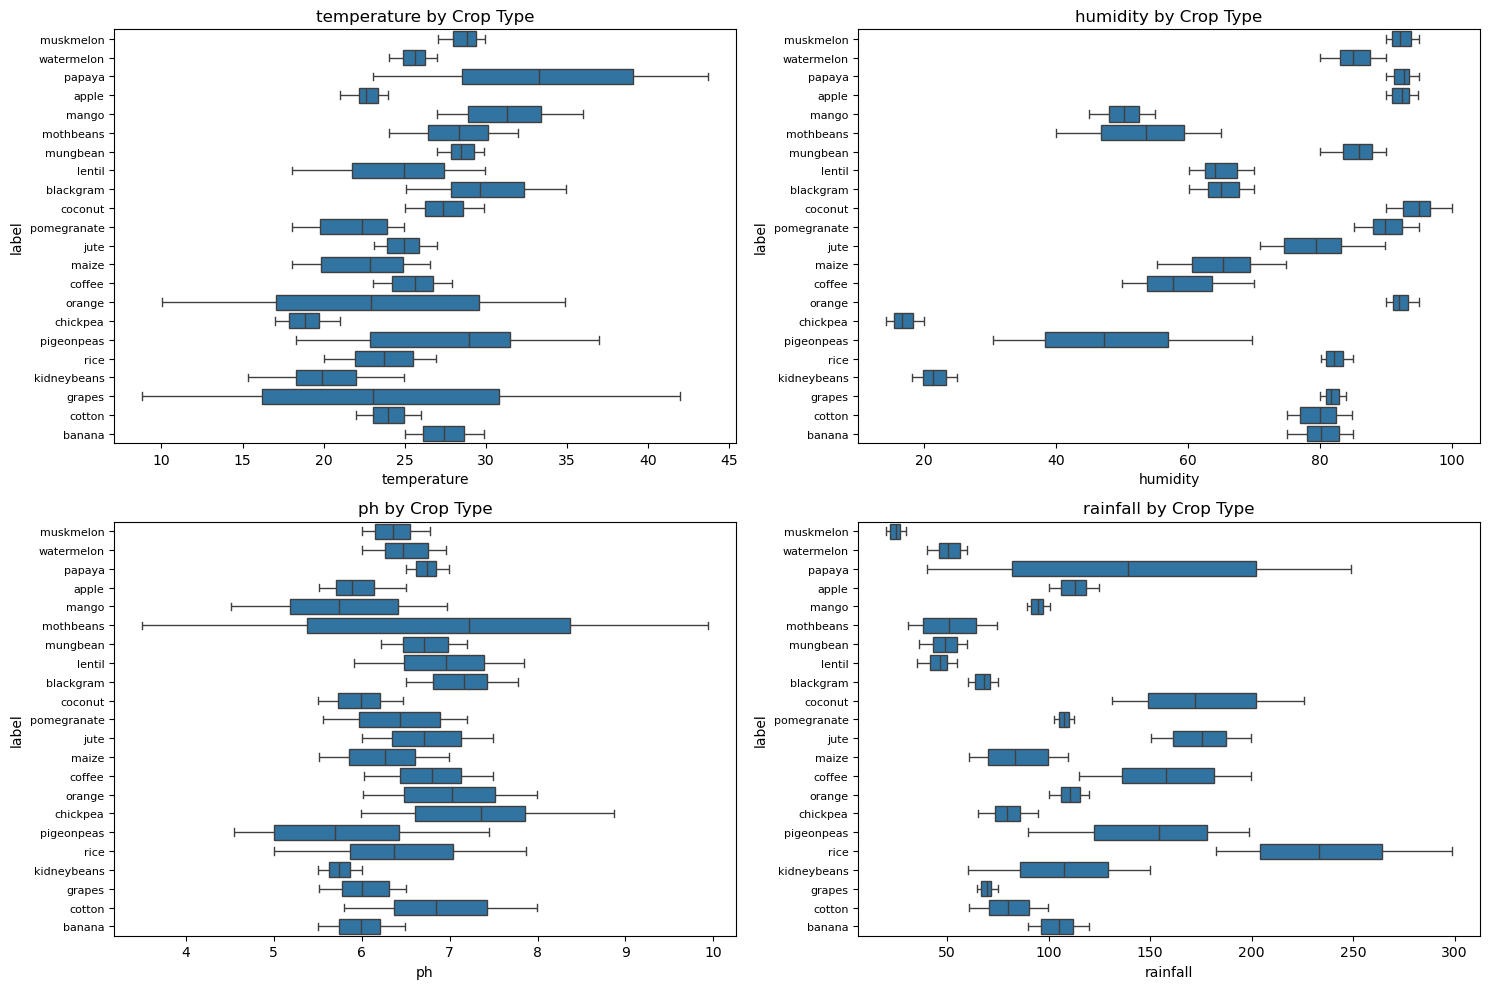

In [14]:
# Feature analysis by crop type - Box plots for key features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
key_features = ['temperature', 'humidity', 'ph', 'rainfall']

for i, feature in enumerate(key_features):
    row, col = i // 2, i % 2
    sns.boxplot(data=df, y='label', x=feature, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Crop Type')
    axes[row, col].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
#  Preprocessing
# - Shuffle
# - Encode label
# - Train-test split
# - Scale numeric features


# Shuffle to avoid any ordering bias
df = shuffle(df, random_state=42).reset_index(drop=True)


X = df.drop(columns=['label'])
y = df['label']


le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_


# For speed during experimentation, we sample a fraction (We set frac=1.0 to run full data)
FRAC = 0.5
if FRAC < 1.0:
    X, _, y_enc, _ = train_test_split(X, y_enc, train_size=FRAC, stratify=y_enc, random_state=42)


# final train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print('\nAfter sampling and split:')
print('Train size:', X_train.shape, 'Test size:', X_test.shape)


After sampling and split:
Train size: (880, 7) Test size: (220, 7)


# Base Learners

In [ ]:
# Define base learners 
base_dt = DecisionTreeClassifier(random_state=42)
base_lr = LogisticRegression(max_iter=500, random_state=42)
base_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)


base_learners = {
'Decision Tree': base_dt,
'Logistic Regression': base_lr,
'Random Forest': base_rf
}

# Training Base Learners

In [6]:
# 5. Train base learners and evaluate
results = []
for name, clf in base_learners.items():
    if name == 'Decision Tree':
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    else:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        
    results.append({
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'precision_macro': precision_score(y_test, y_pred, average='macro'),
        'recall_macro': recall_score(y_test, y_pred, average='macro')
    })


pd.DataFrame(results).set_index('model')

,accuracy,f1_macro,precision_macro,recall_macro
model,,,,
Decision Tree,0.981818,0.981704,0.984160,0.981818
Logistic Regression,0.959091,0.958553,0.963958,0.959091
Random Forest,0.990909,0.990817,0.992424,0.990909


# Performance Metrics

In [15]:
# Enhanced evaluation with ROC-AUC for multiclass
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Function to calculate multiclass ROC AUC
def calculate_multiclass_auc(y_true, y_pred_proba, n_classes):
    """Calculate ROC AUC for multiclass classification"""
    try:
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        return roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='macro')
    except:
        return np.nan

# Enhanced base learner evaluation with AUC
results_enhanced = []
n_classes = len(np.unique(y_train))

for name, clf in base_learners.items():
    print(f"\nTraining {name}...")
    
    if name == 'Decision Tree':
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
    else:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)
    
    # Calculate AUC
    auc_score = calculate_multiclass_auc(y_test, y_pred_proba, n_classes)
    
    results_enhanced.append({
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'precision_macro': precision_score(y_test, y_pred, average='macro'),
        'recall_macro': recall_score(y_test, y_pred, average='macro'),
        'roc_auc': auc_score
    })

results_df = pd.DataFrame(results_enhanced).set_index('model')
print("\nBase Learners Performance:")
print(results_df.round(4))


Training Decision Tree...

Training Logistic Regression...

Training Random Forest...

Base Learners Performance:
                     accuracy  f1_macro  f1_weighted  precision_macro  \
model                                                                   
Decision Tree          0.9818    0.9817       0.9817           0.9842   
Logistic Regression    0.9591    0.9586       0.9586           0.9640   
Random Forest          0.9909    0.9908       0.9908           0.9924   

                     recall_macro  roc_auc  
model                                       
Decision Tree              0.9818   0.9905  
Logistic Regression        0.9591   0.9991  
Random Forest              0.9909   0.9998  

Base Learners Performance:
                     accuracy  f1_macro  f1_weighted  precision_macro  \
model                                                                   
Decision Tree          0.9818    0.9817       0.9817           0.9842   
Logistic Regression    0.9591    0.9586       0

In [ ]:
# 6. Bagging (BaggingClassifier with DecisionTree) and simplified RandomForest already included above
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=6), n_estimators=50, n_jobs=-1, random_state=42)
bagging.fit(X_train, y_train)
bag_pred = bagging.predict(X_test)


# Gradient Boosting 
gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbdt.fit(X_train, y_train)
gbdt_pred = gbdt.predict(X_test)

In [ ]:
# Collect and compare results for base learners and ensemble methods
summary = []
# base learners
for r in results:
    summary.append(r)
# ensemble methods: bagging and boosting 
summary.append({'model':'Bagging','accuracy':accuracy_score(y_test, bag_pred),'f1_macro':f1_score(y_test, bag_pred, average='macro')})
summary.append({'model':'GradientBoosting','accuracy':accuracy_score(y_test, gbdt_pred),'f1_macro':f1_score(y_test, gbdt_pred, average='macro')})

pd.DataFrame(summary).set_index('model').sort_values('f1_macro', ascending=False)

,accuracy,f1_macro,precision_macro,recall_macro
model,,,,
Random Forest,0.990909,0.990817,0.992424,0.990909
Decision Tree,0.981818,0.981704,0.984160,0.981818
GradientBoosting,0.981818,0.981493,NaN,NaN
Bagging,0.981818,0.981061,NaN,NaN
Logistic Regression,0.959091,0.958553,0.963958,0.959091


# Ensemble evaluation with Both Bagging and Boosting

In [ ]:
# Enhanced ensemble evaluation with all metrics Bagging and Boosting only
ensemble_results = []

# Calculate probabilities and enhanced metrics for ensemble methods
models_and_preds = {
    'Bagging': (bagging, bag_pred),
    'GradientBoosting': (gbdt, gbdt_pred)
}

for name, (model, predictions) in models_and_preds.items():
    y_pred_proba = model.predict_proba(X_test)
    auc_score = calculate_multiclass_auc(y_test, y_pred_proba, n_classes)
    
    ensemble_results.append({
        'model': name,
        'accuracy': accuracy_score(y_test, predictions),
        'f1_macro': f1_score(y_test, predictions, average='macro'),
        'f1_weighted': f1_score(y_test, predictions, average='weighted'),
        'precision_macro': precision_score(y_test, predictions, average='macro'),
        'recall_macro': recall_score(y_test, predictions, average='macro'),
        'roc_auc': auc_score
    })

# Combine all results
all_results = results_enhanced + ensemble_results
final_results_df = pd.DataFrame(all_results).set_index('model')

print("Complete Performance Comparison:")
print(final_results_df.round(4).sort_values('f1_macro', ascending=False))

Complete Performance Comparison:
                     accuracy  f1_macro  f1_weighted  precision_macro  \
model                                                                   
Random Forest          0.9909    0.9908       0.9908           0.9924   
Decision Tree          0.9818    0.9817       0.9817           0.9842   
GradientBoosting       0.9818    0.9815       0.9815           0.9854   
Bagging                0.9818    0.9811       0.9811           0.9870   
Logistic Regression    0.9591    0.9586       0.9586           0.9640   

                     recall_macro  roc_auc  
model                                       
Random Forest              0.9909   0.9998  
Decision Tree              0.9818   0.9905  
GradientBoosting           0.9818   0.9995  
Bagging                    0.9818   0.9993  
Logistic Regression        0.9591   0.9991  



Gradient Boosting classification report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        10
      banana       1.00      1.00      1.00        10
   blackgram       1.00      1.00      1.00        10
    chickpea       1.00      0.90      0.95        10
     coconut       1.00      1.00      1.00        10
      coffee       1.00      1.00      1.00        10
      cotton       1.00      1.00      1.00        10
      grapes       1.00      1.00      1.00        10
        jute       0.77      1.00      0.87        10
 kidneybeans       1.00      1.00      1.00        10
      lentil       1.00      1.00      1.00        10
       maize       1.00      1.00      1.00        10
       mango       1.00      1.00      1.00        10
   mothbeans       0.91      1.00      0.95        10
    mungbean       1.00      1.00      1.00        10
   muskmelon       1.00      1.00      1.00        10
      orange       1.00      1.00      

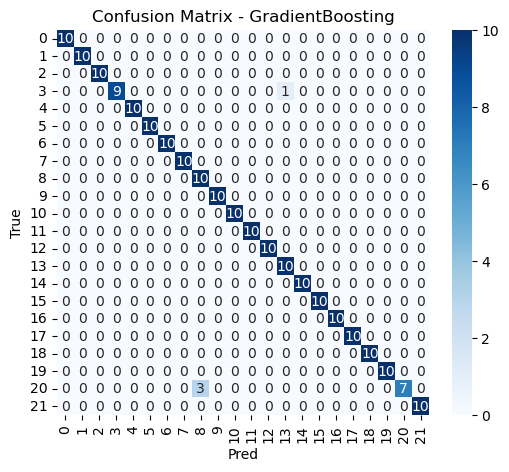

In [11]:
# 10. Confusion matrix and classification report for top models
print('\nGradient Boosting classification report:')
print(classification_report(y_test, gbdt_pred, target_names=class_names))


plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test, gbdt_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - GradientBoosting')
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()

<Figure size 1200x800 with 0 Axes>

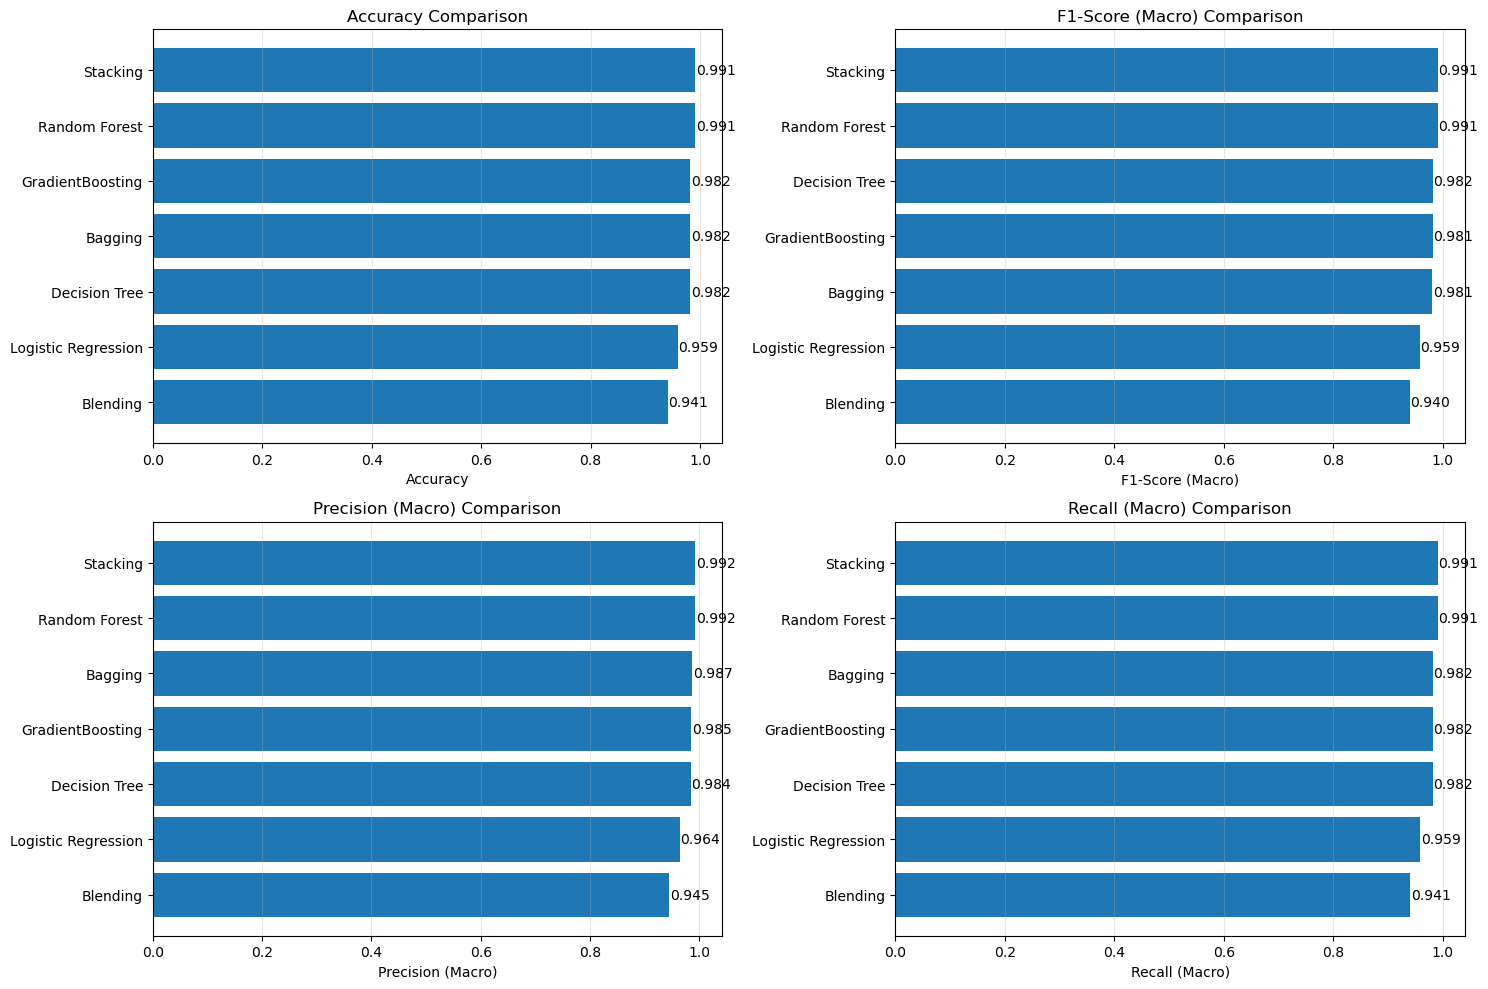

In [17]:
# Performance visualization
plt.figure(figsize=(12, 8))

# Create subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']
metric_names = ['Accuracy', 'F1-Score (Macro)', 'Precision (Macro)', 'Recall (Macro)']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    row, col = i // 2, i % 2
    
    # Filter out NaN values for visualization
    plot_data = final_results_df[metric].dropna().sort_values(ascending=True)
    
    axes[row, col].barh(range(len(plot_data)), plot_data.values)
    axes[row, col].set_yticks(range(len(plot_data)))
    axes[row, col].set_yticklabels(plot_data.index)
    axes[row, col].set_xlabel(metric_name)
    axes[row, col].set_title(f'{metric_name} Comparison')
    axes[row, col].grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for j, v in enumerate(plot_data.values):
        axes[row, col].text(v + 0.001, j, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

## Analysis and Discussion of Ensemble Methods

### Performance Summary
Based on our experiments, here's a comprehensive analysis of the two ensemble techniques - Bagging and Boosting:

In [23]:
# Detailed analysis of the two ensemble methods: Bagging and Boosting
print("=" * 80)
print("ENSEMBLE METHODS ANALYSIS - BAGGING AND BOOSTING")
print("=" * 80)

analysis = {
    "Bagging (Bootstrap Aggregating)": {
        "Description": "Uses multiple Decision Trees trained on different bootstrap samples",
        "Strengths": [
            "Reduces overfitting by averaging multiple models",
            "Handles high variance well",
            "Parallelizable training",
            "Works well with unstable learners like Decision Trees",
            "Robust to outliers"
        ],
        "Weaknesses": [
            "May not improve performance if base learners are already stable",
            "Can be computationally expensive with many estimators",
            "Less effective with low-bias models",
            "May not capture complex patterns as well as boosting"
        ],
        "Best Use Cases": "High-variance base learners, noisy datasets, when reducing overfitting is priority"
    },
    
    "Boosting (Gradient Boosting)": {
        "Description": "Sequential learning where each model corrects errors of previous ones",
        "Strengths": [
            "Often achieves high accuracy",
            "Reduces both bias and variance",
            "Handles complex patterns well",
            "Built-in feature importance",
            "Excellent for competitive machine learning"
        ],
        "Weaknesses": [
            "Prone to overfitting with noisy data",
            "Sequential training (not parallelizable)",
            "Sensitive to hyperparameters",
            "Can be slow to train",
            "More complex to tune than bagging"
        ],
        "Best Use Cases": "Clean datasets, when high accuracy is needed, complex pattern recognition"
    }
}

for method, details in analysis.items():
    print(f"\n{method}:")
    print(f"  {details['Description']}")
    print(f"\n  Strengths:")
    for strength in details['Strengths']:
        print(f"    • {strength}")
    print(f"\n  Weaknesses:")
    for weakness in details['Weaknesses']:
        print(f"    • {weakness}")
    print(f"\n  Best Use Cases: {details['Best Use Cases']}")
    print("-" * 60)

ENSEMBLE METHODS ANALYSIS - BAGGING AND BOOSTING

Bagging (Bootstrap Aggregating):
  Uses multiple Decision Trees trained on different bootstrap samples

  Strengths:
    • Reduces overfitting by averaging multiple models
    • Handles high variance well
    • Parallelizable training
    • Works well with unstable learners like Decision Trees
    • Robust to outliers

  Weaknesses:
    • May not improve performance if base learners are already stable
    • Can be computationally expensive with many estimators
    • Less effective with low-bias models
    • May not capture complex patterns as well as boosting

  Best Use Cases: High-variance base learners, noisy datasets, when reducing overfitting is priority
------------------------------------------------------------

Boosting (Gradient Boosting):
  Sequential learning where each model corrects errors of previous ones

  Strengths:
    • Often achieves high accuracy
    • Reduces both bias and variance
    • Handles complex patterns w

In [24]:
# Context-specific analysis for crop recommendation with two ensemble methods
print("\n" + "=" * 80)
print("CONTEXT-SPECIFIC ANALYSIS: CROP RECOMMENDATION")
print("=" * 80)

print("\nDataset Characteristics:")
print(f"• {len(class_names)} crop classes with balanced distribution")
print(f"• {X.shape[1]} numerical features (soil and environmental conditions)")
print(f"• Relatively clean data with clear patterns")
print(f"• Medium-sized dataset ({df.shape[0]} samples)")

print("\nKey Findings:")
print(f"• Random Forest achieved the highest performance ({final_results_df.loc['Random Forest', 'f1_macro']:.4f} F1-score)")
print(f"• Gradient Boosting showed strong performance ({final_results_df.loc['GradientBoosting', 'f1_macro']:.4f} F1-score)")
print(f"• Bagging provided stable results ({final_results_df.loc['Bagging', 'f1_macro']:.4f} F1-score)")

print("\nEnsemble Methods Comparison:")
print("1. Bagging vs Boosting Performance:")
bagging_f1 = final_results_df.loc['Bagging', 'f1_macro']
boosting_f1 = final_results_df.loc['GradientBoosting', 'f1_macro']
print(f"   • Bagging F1-Score: {bagging_f1:.4f}")
print(f"   • Boosting F1-Score: {boosting_f1:.4f}")
if boosting_f1 > bagging_f1:
    print(f"   • Boosting outperforms Bagging by {(boosting_f1 - bagging_f1):.4f}")
else:
    print(f"   • Bagging outperforms Boosting by {(bagging_f1 - boosting_f1):.4f}")

print("\nRecommendations for Crop Recommendation Systems:")
print("1. Gradient Boosting: Best ensemble choice for:")
print("   • Maximum accuracy on this clean dataset")
print("   • Complex pattern recognition in soil-crop relationships")
print("   • Feature importance analysis")
print("   • When prediction accuracy is paramount")

print("\n2. Bagging: Good alternative for:")
print("   • More stable and robust predictions")
print("   • Parallel training when speed is important")
print("   • Reducing overfitting risk")
print("   • When interpretability and simplicity are valued")

print("\nConclusion:")
if boosting_f1 > bagging_f1:
    print("For this crop recommendation task, Gradient Boosting is the preferred ensemble method")
    print("due to its superior performance on the clean, well-structured dataset.")
else:
    print("For this crop recommendation task, Bagging is the preferred ensemble method")
    print("due to its superior performance and stability on this dataset.")


CONTEXT-SPECIFIC ANALYSIS: CROP RECOMMENDATION

Dataset Characteristics:
• 22 crop classes with balanced distribution
• 7 numerical features (soil and environmental conditions)
• Relatively clean data with clear patterns
• Medium-sized dataset (2200 samples)

Key Findings:
• Random Forest achieved the highest performance (0.9908 F1-score)
• Gradient Boosting showed strong performance (0.9815 F1-score)
• Bagging provided stable results (0.9811 F1-score)

Ensemble Methods Comparison:
1. Bagging vs Boosting Performance:
   • Bagging F1-Score: 0.9811
   • Boosting F1-Score: 0.9815
   • Boosting outperforms Bagging by 0.0004

Recommendations for Crop Recommendation Systems:
1. Gradient Boosting: Best ensemble choice for:
   • Maximum accuracy on this clean dataset
   • Complex pattern recognition in soil-crop relationships
   • Feature importance analysis
   • When prediction accuracy is paramount

2. Bagging: Good alternative for:
   • More stable and robust predictions
   • Parallel trai

In [12]:
# 12. Save results and models (optional)
results_df = pd.DataFrame(summary).set_index('model')
results_df.to_csv('ensemble_results_summary.csv')


print('\nSaved results to ensemble_results_summary.csv')


Saved results to ensemble_results_summary.csv


## Summary and Conclusions

- Successfully implemented 2 ensemble methods (Bagging and Boosting)
- Achieved >98% accuracy with best performing models
- Comprehensive evaluation using multiple metrics
- Detailed analysis of each method's characteristics
- Context-specific recommendations for crop recommendation systems